# Korzystając z operacji na RDD i pliku z logami Apache2: 

1. Narysować wykres rankingu najpopularniejszych stron źródłowych (referer), z wyłączeniem domeny semicomplete.com

2. Narysować wykres rankingu pobieranych plików graficznych

3. Narysować średni dobowy wykres liczby wywołań (request) na minutę w zależności od czasu.

4. Narysować wykres (pie chart) popularności systemów operacyjnych klienta

5. Oszacować jaki procent ruchu generują boty. Porównać co najmniej 2 sposoby oszacowania.

6. Narysować mapę z lokalizacjami klientów

In [1]:
import matplotlib.pyplot as plt
import re
import datetime
import geoip2.database
import folium
from IPython.display import display

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
logs_rdd = sc.textFile("apache_logs")

### 1. Narysować wykres rankingu najpopularniejszych stron źródłowych (referer), z wyłączeniem domeny semicomplete.com

In [3]:
# Funkcja do wyodrębniania referera z każdej linii logu
def extract_referer(line):
    match = re.search(r'\"(http[^\"]+)\"', line)  
    if match:
        referer = match.group(1)
        return referer if "semicomplete.com" not in referer else ""
    return ""

In [4]:
# Przetwarzanie logów do uzyskania refererów
referers = logs_rdd \
    .map(extract_referer) \
    .filter(lambda ref: ref != "") \
    .map(lambda ref: (ref, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda x: x[1], ascending=False)

In [5]:
# 10 najczęściej występujących refererów
referers_list = referers.take(10)

In [6]:
# Rozdzielanie danych na referery i liczba odwiedzin
labels, counts = zip(*referers_list)

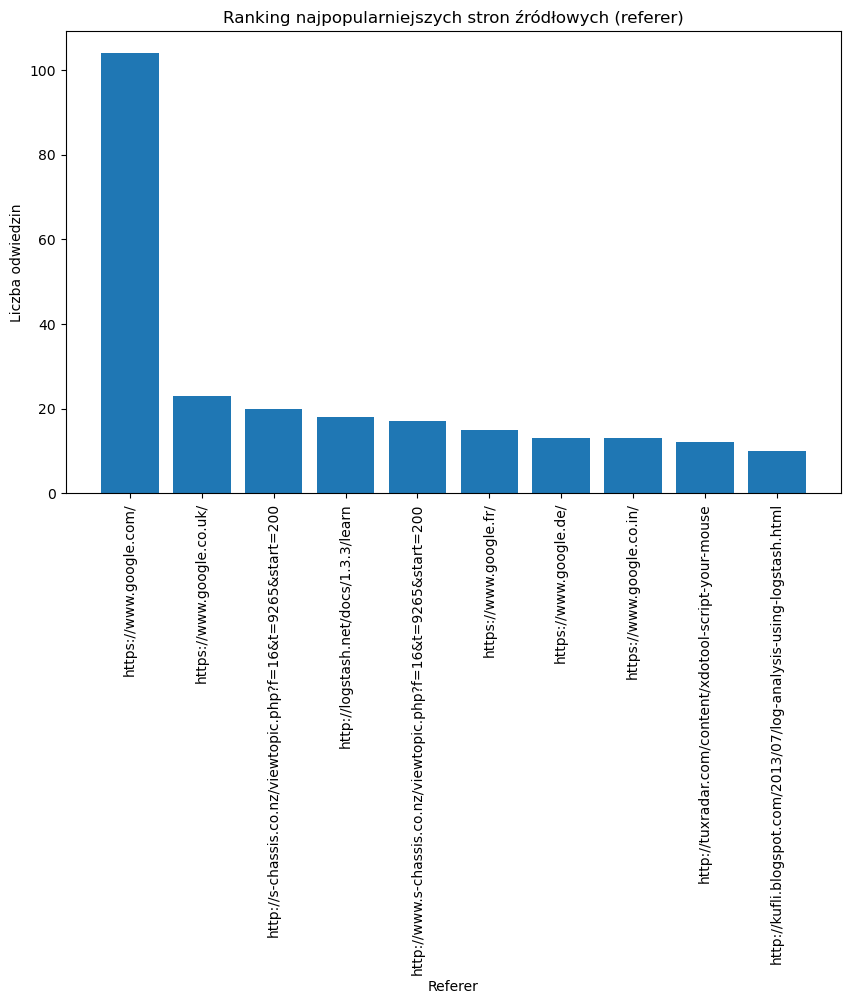

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xticks(rotation=90)
plt.title('Ranking najpopularniejszych stron źródłowych (referer)')
plt.xlabel('Referer')
plt.ylabel('Liczba odwiedzin')
plt.show()

### 2. Narysować wykres rankingu pobieranych plików graficznych

In [8]:
# Funkcja do wyodrębniania plików graficznych z logów
def extract_image_file(line):
    match = re.search(r'GET\s+([^\s]+)', line)  
    if match:
        file = match.group(1)  
        if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
            return file
    return ""

In [9]:
# Przetwarzanie logów w celu uzyskania plików graficznych
image_files = logs_rdd \
    .map(extract_image_file) \
    .filter(lambda file: file != "") \
    .map(lambda file: (file, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda x: x[1], ascending=False)

In [10]:
image_files_list = image_files.take(10)

In [11]:
labels, counts = zip(*image_files_list)

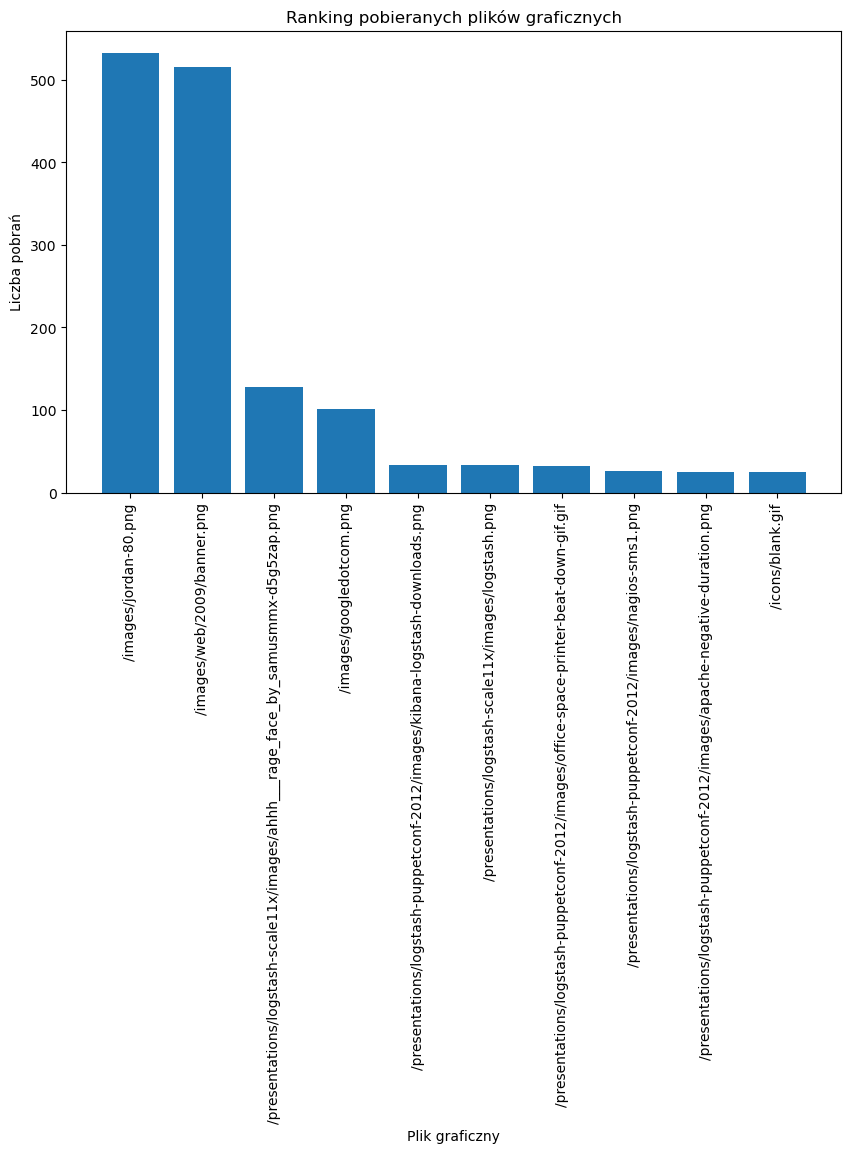

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xticks(rotation=90)
plt.title('Ranking pobieranych plików graficznych')
plt.xlabel('Plik graficzny')
plt.ylabel('Liczba pobrań')
plt.show()

### 3. Narysować średni dobowy wykres liczby wywołań (request) na minutę w zależności od czasu.

In [13]:
# Funkcja do wyodrębniania czasu z linii logu
def extract_time(line):
    # Format czasowy zgodny z fromatem logu Apache
    match = re.search(r'\[(\d{2}/\w+/\d{4}:\d{2}:\d{2}:\d{2})', line)  
    if match:
        time_str = match.group(1)
        dt = datetime.datetime.strptime(time_str, "%d/%b/%Y:%H:%M:%S")
        return dt.strftime("%H:%M") 
    return ""

In [14]:
# Przetwarzanie logów w celu uzyskania liczby zapytań na minutę
requests_per_minute = logs_rdd \
    .map(extract_time) \
    .filter(lambda time: time != "") \
    .map(lambda time: (time, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortByKey() 

In [15]:
requests_per_minute_list = requests_per_minute.collect()

In [16]:
# Rozdzielamy dane na listy minut i liczby zapytań
minutes, counts = zip(*requests_per_minute_list)

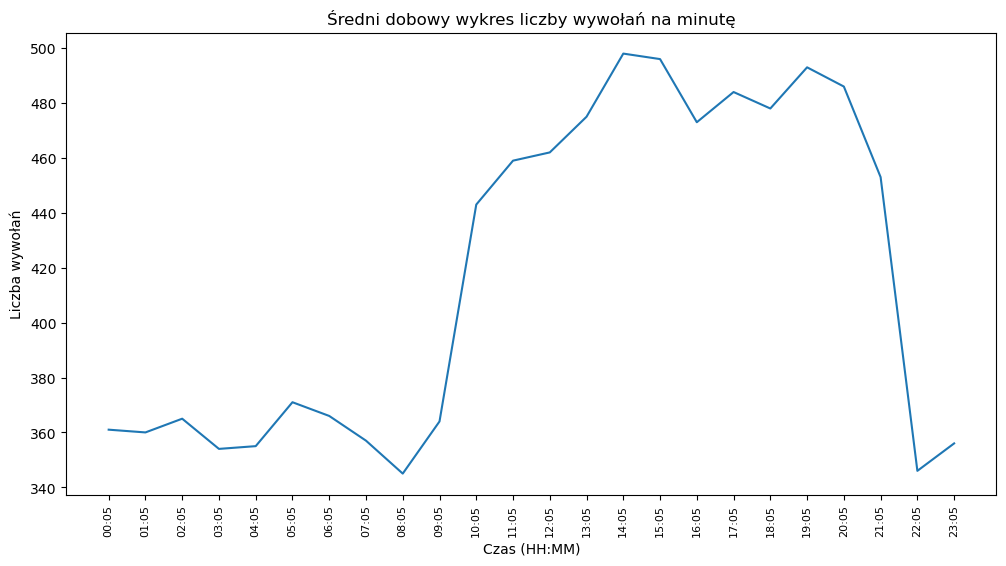

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(minutes, counts)
plt.xticks(rotation=90, fontsize=8)
plt.title('Średni dobowy wykres liczby wywołań na minutę')
plt.xlabel('Czas (HH:MM)')
plt.ylabel('Liczba wywołań')
plt.show()

### 4. Narysować wykres (pie chart) popularności systemów operacyjnych klienta

In [18]:
# Funkcja do wyodrębniania systemu operacyjnego z User-Agent
def extract_os(line):
    # Poszukiwanie user-agent na końcu linii
    match = re.search(r'"([^"]*)"$', line)
    if match:
        user_agent = match.group(1)
        user_agent = user_agent.lower() 
        if "windows" in user_agent:
            return "Windows"
        elif "linux" in user_agent:
            return "Linux"
        elif "mac" in user_agent:
            return "Mac"
        else:
            return "Other"
    return "Other"

In [19]:
os_counts = logs_rdd \
    .map(extract_os) \
    .map(lambda os: (os, 1)) \
    .reduceByKey(lambda a, b: a + b)

In [20]:
os_counts_list = os_counts.collect()

In [21]:
# Rodział danych na systemy operacyjne i liczby wystąpień
labels, sizes = zip(*os_counts_list)

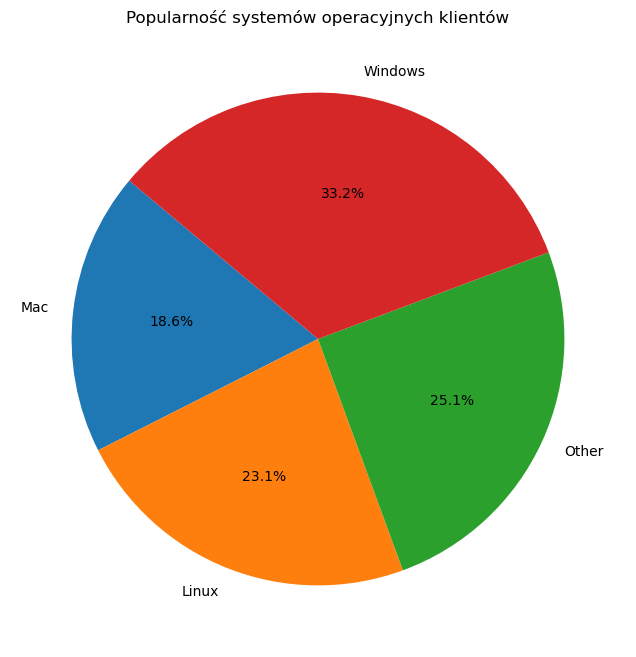

In [22]:
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Popularność systemów operacyjnych klientów')
plt.show()

### 5. Oszacować jaki procent ruchu generują boty. Porównać co najmniej 2 sposoby oszacowania.

In [23]:
# 1. Metoda
# Funkcja do identyfikowania botów na podstawie User-Agent
def is_bot(line):
    match = re.search(r'"([^"]*)"$', line)  
    if match:
        user_agent = match.group(1).lower() 
        # Sprawdzenie słów kluczowych dla User-Agent czy jest botem
        return any(keyword in user_agent for keyword in ["bot", "spider", "crawl", "scrap", "httpclient", "curl", "wget"])
    return False

In [24]:
#  Filtracja zapytań od botów i zliczanie ich 
bot_traffic_1 = logs_rdd.filter(is_bot).count()

In [25]:
total_requests = logs_rdd.count()

In [26]:
bot_traffic_percentage_1 = (bot_traffic_1 / total_requests) * 100
print(f"Procent ruchu generowanego przez boty (metoda 1): {bot_traffic_percentage_1:.2f}%")

Procent ruchu generowanego przez boty (metoda 1): 12.97%


In [27]:
# 2. Metoda
# Funkcja do wyodrębniania adresu IP z linii logu
def extract_ip(line):
    match = re.search(r'^(\S+)', line)  
    if match:
        return match.group(1)
    return ""

In [28]:
# Liczenie liczby zapytań z każdego adresu IP
ip_counts = logs_rdd \
    .map(extract_ip) \
    .map(lambda ip: (ip, 1)) \
    .reduceByKey(lambda a, b: a + b)

In [29]:
# Ustawienie progu zapytań, aby uznać IP za bota 
threshold = 10
bot_ips = ip_counts.filter(lambda x: x[1] > threshold).count()

In [30]:
total_ips = ip_counts.count()
bot_traffic_percentage_2 = (bot_ips / total_ips) * 100

In [31]:
print(f"Procent ruchu generowanego przez boty (metoda 2): {bot_traffic_percentage_2:.2f}%")

Procent ruchu generowanego przez boty (metoda 2): 7.07%


### 6.Narysować mapę z lokalizacjami klientów

In [32]:
def extract_ip(line):
    match = re.search(r'^(\S+)', line)  
    if match:
        return match.group(1)
    return None

In [33]:
# Funkcja do uzyskiwania lokalizacji na podstawie adresu IP
def get_location(ip):
    try:
        # Łączenie z bazą GeoLite2-City
        with geoip2.database.Reader('GeoLite2-City.mmdb') as reader:
            response = reader.city(ip)
            # Otrzymanie szer. i dł. geograficznej 
            return (response.location.latitude, response.location.longitude)
    except:
        return None

In [34]:
# Przetwarzanie logów do uzyskania lokalizacji 
locations = logs_rdd \
    .map(extract_ip) \
    .filter(lambda ip: ip is not None) \
    .map(get_location) \
    .filter(lambda loc: loc is not None) \
    .collect()

In [35]:
# Tworzenie mapy z lokalizacjami klientów
m = folium.Map(location=[0, 0], zoom_start=2)

In [38]:
# Dodanie markera na mape, ograniczenie do 1000 klientów ponieważ jest ich zbyt duża liczba
for loc in locations[:1000]:
    folium.Marker(location=loc).add_to(m)

In [39]:
m